# <font color='green'>Комментарий наставника</font> 

Привет! 

Кажется, всё хорошо. Метрик много, выводов тоже, но по крайней мере ключевые расчитаны правильно и последовательно. Хочется верить, что я ничего не упустил. 

Если вдруг я выясню какой-то нюанс по результатам проверки других работ, который забыл или упустил в твоей работе, то обязательно обсужу это на созвоне. 

Идея собственного личного фидбека о сервисе мне нравится. Это, конечно, очень опасный путь (особенно в части всяких рекомендательных сервисов), но как первый шаг - очень даже хорошая идея.

------------

# Шаг 1. Загрузим данные и подготовим их к анализу
   - Загрузить данные о визитах, заказах и расходах. 
   - Оптимизировать данные для анализа. 
   - Убедиться, что тип данных в каждой колонке — правильный. 

Путь к файлам: 
   - __/datasets/visits_log.csv__ 
   - __/datasets/orders_log.csv__ 
   - __/datasets/costs.csv__

------------

Изучем данные логов сервера с информацией о посещениях сайта

In [1]:
from scipy import stats as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
visits = pd.read_csv('/datasets/visits_log.csv')

In [2]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358532 entries, 0 to 358531
Data columns (total 5 columns):
Uid          358532 non-null uint64
Device       358532 non-null object
End Ts       358532 non-null object
Source Id    358532 non-null int64
Start Ts     358532 non-null object
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [3]:
visits.head(10)

,Uid,Device,End Ts,Source Id,Start Ts
0,16879256277535980062,touch,20.12.2017 17:38,4,20.12.2017 17:20
1,104060357244891740,desktop,19.02.2018 17:21,2,19.02.2018 16:53
2,7459035603376831527,touch,01.07.2017 1:54,5,01.07.2017 1:54
3,16174680259334210214,desktop,20.05.2018 11:23,9,20.05.2018 10:59
4,9969694820036681168,desktop,27.12.2017 14:06,3,27.12.2017 14:06
5,16007536194108375387,desktop,03.09.2017 21:36,5,03.09.2017 21:35
6,6661610529277171451,desktop,30.01.2018 12:09,1,30.01.2018 11:13
7,11423865690854540312,touch,05.11.2017 15:15,3,05.11.2017 15:14
8,2987360259350925644,desktop,19.07.2017 10:44,3,19.07.2017 10:41
9,1289240080042562063,desktop,08.11.2017 13:43,5,08.11.2017 13:42


Тип данных в столбцах _End Ts_ и _End Ts_ не соотвествует необходимым и требует изменение на тип _datetime64[ns]_

In [4]:
visits['End Ts'] = pd.to_datetime(visits['End Ts'], format="%d.%m.%Y %H:%M")
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'], format="%d.%m.%Y %H:%M")

Просмотрим данные в разрезе девайсов и рекламных источников, из которого пришел пользователь 

In [5]:
visits.groupby(['Device', 'Source Id']).agg({'Uid': ['count', 'nunique']})

Uid        
                   count nunique
Device  Source Id               
desktop 1          25775   13172
        2          35541   18257
        3          65652   57420
        4          67548   55607
        5          49910   42053
        6              5       5
        7             28      26
        9          10103    7079
        10          7351    5763
touch   1           8168    6094
        2          11932    8609
        3          19796   18600
        4          34105   29313
        5          16801   15375
        6              1       1
        7              8       8
        9           3154    2402
        10          2654    2381

Расчитаем время в минутах которое пользователь проводит в Яндекс.Афиши

In [6]:
visits['session_duration_minutes'] = (visits['End Ts'] - visits['Start Ts']) / np.timedelta64(1,'m')
visits['session_duration_minutes'] = visits['session_duration_minutes'].round().astype('int')

Проверим на наличие отритцательных данныхв столбце __session_duration_minutes__

In [7]:
visits[visits['session_duration_minutes'] <0].shape[0]

2

существует две ошибки так как дата окончания меньше даты просмотрим данные 

In [8]:
visits[visits['session_duration_minutes'] <0]

,Uid,Device,End Ts,Source Id,Start Ts,session_duration_minutes
4181,13092152539246794986,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,-32
177972,4621202742905035453,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,-46


Не могу определить причину данной ошибки и т.к. все 2 позициии имеют отритцательное значение предлагаю в дальнейшем анализе не использовать

In [9]:
visits = visits[visits['session_duration_minutes'] >=0]

Определим первое время входа для каждого пользователя 

In [10]:
first_visits_dates = visits.groupby('Uid')['Start Ts'].min()
first_visits_dates.name = 'application_start_date'
visits = visits.join(first_visits_dates,on='Uid')

Чтобы в дальнейшем расчитать пользовательские метрики выделим в отдельные столбцы год, месяц и неделю, а также полную дату

In [11]:
visits['session_year'] = visits['Start Ts'].dt.year 
visits['session_month'] = visits['Start Ts'].dt.month 
visits['session_week'] = visits['Start Ts'].dt.week
visits['session_date'] = visits['Start Ts'].dt.date

In [12]:
visits.head()

,Uid,Device,End Ts,Source Id,Start Ts,session_duration_minutes,application_start_date,session_year,session_month,session_week,session_date
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,18,2017-12-20 17:20:00,2017,12,51,2017-12-20
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,28,2018-02-19 16:53:00,2018,2,8,2018-02-19
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,0,2017-07-01 01:54:00,2017,7,26,2017-07-01
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,24,2018-03-09 20:05:00,2018,5,20,2018-05-20
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,0,2017-12-27 14:06:00,2017,12,52,2017-12-27


In [13]:
visits.duplicated().sum()

0

Изучем __данные о заказах__

In [14]:
orders = pd.read_csv('/datasets/orders_log.csv')


In [15]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [16]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Необходимо изменить тип данных в столбце _Buy Ts_ на _datetime64[ns]_

In [17]:
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'], format="%Y-%m-%d %H:%M:%S")
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null datetime64[ns]
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


Определим дату первой покупки

In [18]:
first_orders_dates = orders.groupby('Uid')['Buy Ts'].min()
first_orders_dates.name = 'start_date_purchase'
orders = orders.join(first_orders_dates,on='Uid')

In [19]:
orders.head()

,Buy Ts,Revenue,Uid,start_date_purchase
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00


In [20]:
orders.duplicated().sum()

0

Данная таблица понадобиться для определния как воронки продаж, так и для расчет среднего времени от первого захода пользователя на Яндекс.Афиши до осуществления первого заказа.

In [21]:
time_to_purchase = pd.concat([first_visits_dates, first_orders_dates], axis=1) 

In [22]:
purchases = orders.groupby('Uid').agg({'Buy Ts': 'count'})

In [23]:
time_to_purchase = pd.concat([time_to_purchase, purchases], axis=1) 

In [24]:
time_to_purchase.head()

,application_start_date,start_date_purchase,Buy Ts
Uid,,,
11863502262781,2018-03-01 17:27:00,NaT,NaN
49537067089222,2018-02-06 15:55:00,NaT,NaN
297729379853735,2017-06-07 18:47:00,NaT,NaN
313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,1.0
325320750514679,2017-09-30 14:29:00,NaT,NaN


Изучем информацию о затратах на маркетинг

In [25]:
costs = pd.read_csv('/datasets/costs.csv')
costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Необходимо изменить данные в столбце _dt_ на _datetime64[ns]_

In [26]:
costs['dt'] = pd.to_datetime(costs['dt'], format="%Y-%m-%d")
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [27]:
costs.duplicated().sum()

0

Резюме о проделанной работе
----

   1. Загружены данные о визитах, заказах и расходах:
       - __/datasets/visits_log.csv__ 
       - __/datasets/orders_log.csv__ 
       - __/datasets/costs.csv__.
   2. В таблице __visits__ проделана следующая работа:
       - изменен тип данных в столбцах _End Ts_ и _End Ts_ на тип _datetime64[ns]_;
       - расчитано время в минутах каждой сессии;
       - выделены в отдельные столбцы год, месяц, неделю, полную дату
       - определна дата первого входа пользователя.
   3. В таблице __orders__ проделана следующая работа:
       - изменен тип данных в столбце _Buy Ts_ на тип _datetime64[ns]_;
       - определна дата первого заказа.      
   4. В таблице __costs__ проделана следующая работа:
       - изменен тип данных в столбце _dt_ на тип _datetime64[ns]_.
      

------------

# Шаг 2. Построить отчёты и посчитайте метрики
   
   1. __Продукт__:
      - Сколько людей пользуются в день, неделю, месяц?
      - Сколько сессий в день?
      - Сколько длится одна сессия?
      - Как часто люди возвращаются?
   2. __Продажи__:
      - Когда люди начинают покупать?
      - Сколько раз покупают за период?
      - Какой средний чек?
      - Сколько денег приносят? (LTV)
   3. __Маркетинг__
      - Сколько денег потратили? Всего / на каждый источник / по времени.
      - Сколько стоило привлечение одного покупателя из каждого источника?
      - На сколько окупились расходы? (ROI)

------------

# Определим скольков визитов сервиса Яндекс.Афиша
   - целиком 
   - в разрезе только 0 
   - в разрезе без 0


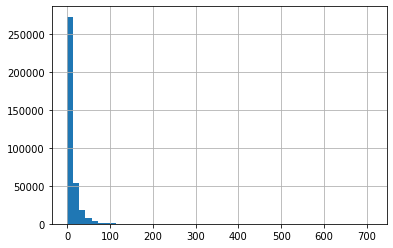

In [28]:
visits['session_duration_minutes'].hist(bins = 50)

In [29]:
analysis_session_duration_minutes = visits[['Device', 'session_duration_minutes']]

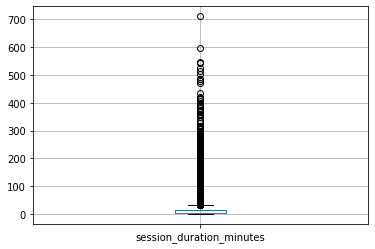

In [30]:
plt.figure()
bp = analysis_session_duration_minutes.boxplot()

In [31]:
analysis_session_duration_minutes.describe()

,session_duration_minutes
count,358530.000000
mean,10.742552
std,16.630634
min,0.000000
25%,2.000000
50%,5.000000
75%,14.000000
max,711.000000


Вывод
----
Видно что существуют выбросы данны и необходимо избавиться от них избавиться

Для того что бы избавиться от выбрасов ограничим время сессии до 18 минут

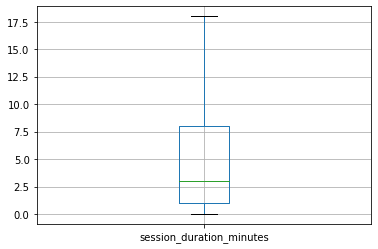

In [32]:
plt.figure()
bp = analysis_session_duration_minutes[analysis_session_duration_minutes['session_duration_minutes'] <= 18].boxplot()

In [33]:
analysis_session_duration_minutes[analysis_session_duration_minutes['session_duration_minutes'] <= 18].describe()

,session_duration_minutes
count,292309.000000
mean,5.029325
std,4.842374
min,0.000000
25%,1.000000
50%,3.000000
75%,8.000000
max,18.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd41fca56d8>]],
      dtype=object)

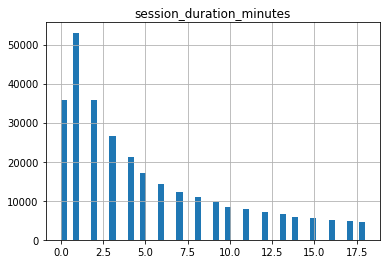

In [34]:
analysis_session_duration_minutes[analysis_session_duration_minutes['session_duration_minutes'] <= 18].hist(bins = 50)

даже для временной переменной ddd сомнительное название
уж лучше тогла честное t
mp 

In [35]:
ddd = analysis_session_duration_minutes[analysis_session_duration_minutes['session_duration_minutes'] <= 18]

In [36]:
duration_all = ddd.groupby('Device').agg({'session_duration_minutes': ['count', 'sum', 'mean', 'median']})
duration_0 = ddd[ddd['session_duration_minutes'] == 0].groupby('Device').agg({'session_duration_minutes': 'count'})
duration_non_0 = ddd[ddd['session_duration_minutes'] !=0].groupby('Device').agg({'session_duration_minutes': ['count', 'sum', 'mean', 'median']})

# <font color='green'>Комментарий наставника</font> 
просто как вариант, можно создать поле duration==0 и включить ег в groupby, тогда не придется делать два датафрейма

# <font color='blue'>Ответ</font> 
Согласен, пока комфортнее так, ет опыта написания кода

In [37]:
duration_all

session_duration_minutes                          
                           count      sum      mean median
Device                                                    
desktop                   208313  1101965  5.289948      4
touch                      83996   368152  4.382971      3

In [38]:
duration_0

,session_duration_minutes
Device,
desktop,23689
touch,12105


In [39]:
duration_non_0

session_duration_minutes                          
                           count      sum      mean median
Device                                                    
desktop                   184624  1101965  5.968699      4
touch                      71891   368152  5.120975      3

In [40]:
dau_session_all = visits.groupby('session_date').agg({'session_duration_minutes': 'count'}).mean()

In [41]:
dau_session_non_0 = visits[visits['session_duration_minutes'] != 0].groupby('session_date').agg({'session_duration_minutes': 'count'}).mean()

In [42]:
'общее количество посещений в день', int(dau_session_all)

('общее количество посещений в день', 984)

In [43]:

'общее количество посещений в день без нулевых сессий', int(dau_session_non_0)

('общее количество посещений в день без нулевых сессий', 886)

Вывод
----
   1. Видно, что распределние "время нахождения" осуществляется по распредлению Пуасона. Среднее время нахождения посетителя на сайте равняется 3 минутам.
   2. Размер сессии зависит от девайса, с которого заходили: с desktop медианное значение времени 4 минуты (7 минут без пустых (меньше 1 минуты) заходов).
   3. Большое количество пустых заходов, при этом доля пустых сессий (время < 1 минуты) для девайсов touch составляет 16,83%, для desktop 12,83%.
   4. Общее количество посещений в день составляет 984 визитов. Без учета сессий длительностью меньше 1 минуты 886 визитов.

Расчитаем сколько людей пользуется приложеним в разрезе дня, недели, месяца

Проведем оценку пользовательской активности и расчитаем метрики:
   - количество уникальных пользователей в день (DAU);
   - количество уникальных пользователей в неделю (WAU);
   - количество уникальных пользователей в месяц (MAU).
   
_Данные рассчитаем целиком для всей выборки и отдельно в разрезе девайсов._

In [44]:
visits_touch = visits[visits['Device'] == 'touch']
visits_desktop = visits[visits['Device'] == 'desktop']

In [45]:
dau_total = visits.groupby('session_date').agg({'Uid': 'nunique'}).mean()
wau_total = visits.groupby(['session_year', 'session_week']).agg({'Uid': 'nunique'}).mean()
mau_total = visits.groupby(['session_year', 'session_month']).agg({'Uid': 'nunique'}).mean()
dau_total_touch = visits_touch.groupby('session_date').agg({'Uid': 'nunique'}).mean()
wau_total_touch = visits_touch.groupby(['session_year', 'session_week']).agg({'Uid': 'nunique'}).mean()
mau_total_touch = visits_touch.groupby(['session_year', 'session_month']).agg({'Uid': 'nunique'}).mean()
dau_total_desktop = visits_desktop.groupby('session_date').agg({'Uid': 'nunique'}).mean()
wau_total_desktop = visits_desktop.groupby(['session_year', 'session_week']).agg({'Uid': 'nunique'}).mean()
mau_total_desktop = visits_desktop.groupby(['session_year', 'session_month']).agg({'Uid': 'nunique'}).mean()


In [46]:
print('Количество уникальных пользователей в целом')
print('Количество уникальных пользователей в день', int(dau_total))
print('Количество уникальных пользователей в неделю', int(wau_total))
print('Количество уникальных пользователей в месяц', int(mau_total))
print()
print('Количество уникальных пользователей для смартфонов и планшетов')
print('Количество уникальных пользователей в день для девайса touch', int(dau_total_touch))
print('Количество уникальных пользователей в неделю для девайса touch', int(wau_total_touch))
print('Количество уникальных пользователей в месяц для девайса touch', int(mau_total_touch))
print()
print('Количество уникальных пользователей для декстопных девайсов')
print('Количество уникальных пользователей в день для девайса desktop', int(dau_total_desktop))
print('Количество уникальных пользователей в неделю для девайса desktop', int(wau_total_desktop))
print('Количество уникальных пользователей в месяц для девайса desktop', int(mau_total_desktop))



Количество уникальных пользователей в целом
Количество уникальных пользователей в день 907
Количество уникальных пользователей в неделю 5716
Количество уникальных пользователей в месяц 23228

Количество уникальных пользователей для смартфонов и планшетов
Количество уникальных пользователей в день для девайса touch 252
Количество уникальных пользователей в неделю для девайса touch 1634
Количество уникальных пользователей в месяц для девайса touch 6825

Количество уникальных пользователей для декстопных девайсов
Количество уникальных пользователей в день для девайса desktop 659
Количество уникальных пользователей в неделю для девайса desktop 4129
Количество уникальных пользователей в месяц для девайса desktop 16724


Вывод по метрике
----

   1. Количество уникальных пользователей, которые приходят с декстопных девайсов на 145% больше, чем с планшетов и мобильников

Расчитаем метрику __sticky factor__ для выборки целиком и в разрезе девайсов.

In [47]:
print('Удержание пользователей в целой выборке')
print('Удержание пользователей в неделю', dau_total * 100 / wau_total)
print('Удеражние пользователей в месяц', dau_total * 100 / mau_total)
print()
print('Удержание пользователей для смартфонов и планшетов')
print('Удержание пользователей в неделю для девайса touch', dau_total_touch * 100 / wau_total_touch)
print('Удержание пользователей в месяц для девайса touch', dau_total_touch * 100 / mau_total_touch)
print()
print('Удержание пользователей для декстопных девайсов')
print('Удержание пользователей в неделю для девайса desktop', dau_total_desktop * 100 / wau_total_desktop)
print('Удержание пользователей в месяц для девайса desktop', dau_total_desktop * 100 / mau_total_desktop)

Удержание пользователей в целой выборке
Удержание пользователей в неделю Uid    15.884409
dtype: float64
Удеражние пользователей в месяц Uid    3.90897
dtype: float64

Удержание пользователей для смартфонов и планшетов
Удержание пользователей в неделю для девайса touch Uid    15.466395
dtype: float64
Удержание пользователей в месяц для девайса touch Uid    3.704447
dtype: float64

Удержание пользователей для декстопных девайсов
Удержание пользователей в неделю для девайса desktop Uid    15.964078
dtype: float64
Удержание пользователей в месяц для девайса desktop Uid    3.941625
dtype: float64


Вывод по метрике
----
Несмотря на то, что «Sticky Factor» напрямую не связан с доходом, он характеризует лояльность и активность аудитории, что в свою очередь влияет на монетизацию и доход, так как чем стабильнее и заинтересованнее пользовательская база, тем быстрее формируется и растет аудитория продукта, а чем она больше, тем больше платежей совершают пользователи. Плюс, как показывает опыт других компаний, существует корреляция между «Sticky factor» и доходом (она составляет около 50-60%), что подтверждает влияние этого показателя на финансовые метрики продукта.

Исходя из данной метрики можно сказат, что она близка к минимальной и говорит она о том, что пользователи не задерживаются в сервисе, вероятно его удержание очень низкое и в нем отсутствует пользовательская база, которая необходима для того, чтобы генерировать доход сервиса.

# <font color='green'>Комментарий наставника</font> 
Так как я имею некоторое отношение к Рамблер/Кассе и кинотеатрам входящим в состав Rambler Group, то могу ответственно заявить: большая часть людей покупает один билет, существенная часть билетов покупается за несколько минут до начала сеанса оффлайн.

Это не противоречит твоим выводам, но тут скорее вопрос в том, какое удержание пользователя нормально для таких сервисов. Поход в кино для существенной доли пользователей - редкое событие. Я, например, вряд ли хожу сильно чаще 2 раз в год. Если одну из покупок совершил я, а вторую, например, кто-то из друзей или членов семьи (покупка нескольких билетов), то так и получается, что пользователь покупает один билет в год. 

# <font color='blue'>Ответ</font> 
С выводом согласен, однако, стоит отметить, что необходимо смотреть в будущее и необходимо создавать культуру потребления данного вида услуг. 

__По фактическим данным можно сказать, что потенциалом роста является удержание клиентов, об этом свидетельствует анализ дальше. И основным выходом для удержания пользователей является:__
   - пока рынок является растущим кажется, что затраты на привлечение более эффективны, чем затраты на удержание;
   - дальнейший анализ показал, что чистое привлечение не эффектино (фактически убыточно). И это мы анализируем только затраты на привлечение без учета "накладных" расходов;
   - параллельно с затратами на привлечение стоит вкладывать во внутренние развитие сервиса направленное на повышение такой пользовательской хараткеристики как __"индивидуальная стоимость перехода с одного сервиса на другой__" - она должна быть психологически неудобно для пользователя;
   - необходимо разработать маркетинговый план по "прививанию лояльности" клиентам к использованию сервиса;
   - все выше сказанное должно базироваться на формировании культуры посещения различных мероприятий и генерирование субкультур потребления
   
__Дальнейший анализ отчасти поттверждает данный вывод__

Расмотрим данные метрики в разрезе рекламного источника

# <font color='green'>Комментарий наставника</font> 
Тут классическая и досадная ошибка, на которую сам 100 раз попадал. Ты передаешь в функцию data, но используешь visits: поэтому все результаты одинаковые.

Вероятнее всего ты сначала написал код, а потом решил выделить его в функцию (это нормально и правильно), но забыл поменять используемые переменные.

# <font color='blue'>Да, спасибо ошибся, и очень здорово, что указал на ошибку</font> 

In [48]:
def vanity_metrics(data):
    dau_total = data.groupby('session_date').agg({'Uid': 'nunique'}).mean()
    wau_total = data.groupby(['session_year', 'session_week']).agg({'Uid': 'nunique'}).mean()
    mau_total = data.groupby(['session_year', 'session_month']).agg({'Uid': 'nunique'}).mean()
    print('Sticky factor', dau_total *100 /  mau_total)

In [49]:

for i in range(1, 11, 1):
    print('рекламный источник', i)
    visits_ad = visits[visits['Source Id'] == i]
    vanity_metrics(visits_ad)
    print()

рекламный источник 1
Sticky factor Uid    4.427882
dtype: float64

рекламный источник 2
Sticky factor Uid    4.386476
dtype: float64

рекламный источник 3
Sticky factor Uid    3.445009
dtype: float64

рекламный источник 4
Sticky factor Uid    3.546766
dtype: float64

рекламный источник 5
Sticky factor Uid    3.499817
dtype: float64

рекламный источник 6
Sticky factor Uid    100.0
dtype: float64

рекламный источник 7
Sticky factor Uid    37.370242
dtype: float64

рекламный источник 8
Sticky factor Uid   NaN
dtype: float64

рекламный источник 9
Sticky factor Uid    3.657732
dtype: float64

рекламный источник 10
Sticky factor Uid    3.681496
dtype: float64



Вывод
----
~Значение метрики Sticky Factor в разрезе рекламных источников повторяет значение выборки, это не дает нам оценить приход лояльных потребителей в разрезе рекламных каналов.~ 

<font color='red'>Как видно из анализа наилучшими результатами по привлечению клиентов обладают рекламный источник № 6 и 7, однако в раннем анализе было видно, что на данный вид рекламы приходится незначительное число переходов. 

Стоит обратить внимение на рекламные источники 1 и 2, так как показатель удержания повторных клиентов для них больше чем всреднем по выборке</font> 

Рассмотрим общее количество визитов

In [50]:
dau = visits.groupby('session_date').agg({'Uid': 'count'}).mean()
wau = visits.groupby(['session_year', 'session_week']).agg({'Uid': 'count'}).mean()
mau = visits.groupby(['session_year', 'session_month']).agg({'Uid': 'count'}).mean()
dau_touch = visits_touch.groupby('session_date').agg({'Uid': 'count'}).mean()
wau_touch = visits_touch.groupby(['session_year', 'session_week']).agg({'Uid': 'count'}).mean()
mau_touch = visits_touch.groupby(['session_year', 'session_month']).agg({'Uid': 'count'}).mean()
dau_desktop = visits_desktop.groupby('session_date').agg({'Uid': 'count'}).mean()
wau_desktop = visits_desktop.groupby(['session_year', 'session_week']).agg({'Uid': 'count'}).mean()
mau_desktop = visits_desktop.groupby(['session_year', 'session_month']).agg({'Uid': 'count'}).mean()

In [51]:
print('Количество пользователей в целом')
print('Количество пользователей в день', int(dau))
print('Количество пользователей в неделю', int(wau))
print('Количество пользователей в месяц', int(mau))
print()
print('Количество пользователей для смартфонов и планшетов')
print('Количество пользователей в день для девайса touch', int(dau_touch))
print('Количество пользователей в неделю для девайса touch', int(wau_touch))
print('Количество пользователей в месяц для девайса touch', int(mau_touch))
print()
print('Количество пользователей для декстопных девайсов')
print('Количество пользователей в день для девайса desktop', int(dau_desktop))
print('Количество пользователей в неделю для девайса desktop', int(wau_desktop))
print('Количество пользователей в месяц для девайса desktop', int(mau_desktop))
print()
print('Во сколько раз для пользователей с декстопных девайсов больше чем со смартфонов и планшетов', dau_desktop/dau_touch)
print('Количество пользователей в неделю для девайса desktop', wau_desktop/wau_touch)
print('Количество пользователей в месяц для девайса desktop', mau_desktop/mau_touch)

Количество пользователей в целом
Количество пользователей в день 984
Количество пользователей в неделю 6764
Количество пользователей в месяц 29877

Количество пользователей для смартфонов и планшетов
Количество пользователей в день для девайса touch 266
Количество пользователей в неделю для девайса touch 1823
Количество пользователей в месяц для девайса touch 8051

Количество пользователей для декстопных девайсов
Количество пользователей в день для девайса desktop 719
Количество пользователей в неделю для девайса desktop 4941
Количество пользователей в месяц для девайса desktop 21825

Во сколько раз для пользователей с декстопных девайсов больше чем со смартфонов и планшетов Uid    2.703314
dtype: float64
Количество пользователей в неделю для девайса desktop Uid    2.710761
dtype: float64
Количество пользователей в месяц для девайса desktop Uid    2.710761
dtype: float64


Вывод 
------

   1. Количество общих визитов, которые приходят с декстопных девайсов на 171% больше, чем с планшетов и мобильников

Расчитаем долю уникальных потребителей в общей массе визитов


In [52]:
print('В целой выборке')
print('Отношение уникальных пользователей к общему числу визитов в день', dau_total / dau)
print('Отношение уникальных пользователей к общему числу визитов в неделю', wau_total / wau)
print('Отношение уникальных пользователей к общему числу визитов в месяц', mau_total / mau)
print()
print('Для смартфонов и планшетов')
print('Отношение уникальных пользователей к общему числу визитов в день для девайса touch', dau_total_touch / dau_touch)
print('Отношение уникальных пользователей к общему числу визитов в неделю для девайса touch', wau_total_touch / wau_touch)
print('Отношение уникальных пользователей к общему числу визитов в месяц для девайса touch', mau_total_touch /mau_touch)
print()
print('Для декстопных девайсов')
print('Отношение уникальных пользователей к общему числу визитов в день для девайса desktop', dau_total_desktop /dau_desktop)
print('Отношение уникальных пользователей к общему числу визитов в неделю для девайса desktop', wau_total_touch / wau_desktop)
print('Отношение уникальных пользователей к общему числу визитов в месяц для девайса desktop', mau_total_desktop / mau_desktop)


В целой выборке
Отношение уникальных пользователей к общему числу визитов в день Uid    0.921845
dtype: float64
Отношение уникальных пользователей к общему числу визитов в неделю Uid    0.845009
dtype: float64
Отношение уникальных пользователей к общему числу визитов в месяц Uid    0.777455
dtype: float64

Для смартфонов и планшетов
Отношение уникальных пользователей к общему числу визитов в день для девайса touch Uid    0.949906
dtype: float64
Отношение уникальных пользователей к общему числу визитов в неделю для девайса touch Uid    0.896728
dtype: float64
Отношение уникальных пользователей к общему числу визитов в месяц для девайса touch Uid    0.84768
dtype: float64

Для декстопных девайсов
Отношение уникальных пользователей к общему числу визитов в день для девайса desktop Uid    0.91617
dtype: float64
Отношение уникальных пользователей к общему числу визитов в неделю для девайса desktop Uid    0.330803
dtype: float64
Отношение уникальных пользователей к общему числу визитов в мес

Вывод
-----

Как видно пользователи в большенстве своем заходят в Яндекс.Афиши один раз в день. Для пользователей с декстопных девайсов заходить могут больше одного раза в течении недели (можно сделать предположение, что период планирования для пользователей декстопных девайсов приблизительно равен одной недели). Менее 25% пользователей заходят в сервис более двух раз в месяц

Посчитаем параметры воронки продаж

In [53]:
time_to_purchase['number_repeat_purchases'] = time_to_purchase['Buy Ts'] - 1

In [54]:
share = time_to_purchase['start_date_purchase'].count() * 100 / time_to_purchase['application_start_date'].count()
'Отношение количества визитов к количеству покупок', share

('Отношение количества визитов к количеству покупок', 16.006994815246593)

In [55]:
'Отношение количества покупок к количеству повторных покупок', time_to_purchase['number_repeat_purchases'].sum() * 100 / time_to_purchase['start_date_purchase'].count()

('Отношение количества покупок к количеству повторных покупок',
 38.03630588943953)

Вывод 
----
   1. Параметры воронки продаж: из 100% пользователей 16% делает одну покупку, из которых 38,04% совершают повторную покупку т.е. из 100% совершает 2 и более покупок только 6% посетителей

Ответим на вопрос: "Когда люди начинают покупать?"

In [56]:
time_to_purchase['days_first_purchase'] = (time_to_purchase['start_date_purchase'] - time_to_purchase['application_start_date']) / np.timedelta64(1,'D')

In [57]:
time_to_purchase[time_to_purchase['days_first_purchase'] < 0].info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 868 entries, 2551852515556206 to 18396128934054549559
Data columns (total 5 columns):
application_start_date     868 non-null datetime64[ns]
start_date_purchase        868 non-null datetime64[ns]
Buy Ts                     868 non-null float64
number_repeat_purchases    868 non-null float64
days_first_purchase        868 non-null float64
dtypes: datetime64[ns](2), float64(3)
memory usage: 40.7 KB


In [58]:
time_to_purchase[time_to_purchase['days_first_purchase'] < 0].describe()

,Buy Ts,number_repeat_purchases,days_first_purchase
count,868.000000,868.000000,868.000000
mean,2.262673,1.262673,-0.133837
std,9.166794,9.166794,0.162818
min,1.000000,0.000000,-0.959028
25%,1.000000,0.000000,-0.166146
50%,2.000000,1.000000,-0.070139
75%,2.000000,1.000000,-0.030556
max,239.000000,238.000000,-0.001389


In [59]:
time_to_purchase[time_to_purchase['days_first_purchase'] > 0].describe()

,Buy Ts,number_repeat_purchases,days_first_purchase
count,34068.000000,34068.000000,34068.000000
mean,1.364947,0.364947,18.120953
std,3.255031,3.255031,48.512413
min,1.000000,0.000000,0.000694
25%,1.000000,0.000000,0.003472
50%,1.000000,0.000000,0.014583
75%,1.000000,0.000000,3.081944
max,238.000000,237.000000,363.294444


Так как данные об отритцательных значениях меньше 1 минуты, можно сделать вывод о том, что данные в столбце _"Buy Ts"_ являются более точными, соотвественно округлим значения в столбце _"days_first_purchase"_ до целого а отритцательные данные приравняем к 0

In [60]:
time_to_purchase.loc[time_to_purchase['days_first_purchase'] < 1, 'days_first_purchase'] = 0
time_to_purchase['days_first_purchase'] = time_to_purchase['days_first_purchase'].fillna(-1)
time_to_purchase['days_first_purchase'] = time_to_purchase['days_first_purchase'].astype(int)

In [61]:
time_to_purchase = time_to_purchase[time_to_purchase['days_first_purchase']>=0]

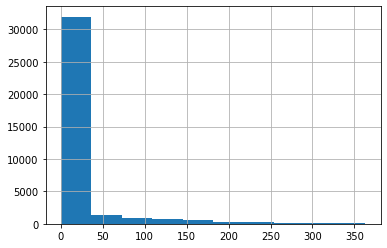

In [62]:
time_to_purchase['days_first_purchase'].hist(bins = 10)

In [63]:
time_to_purchase['days_first_purchase'].describe()


count    36523.000000
mean        16.729869
std         46.959088
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        363.000000
Name: days_first_purchase, dtype: float64

In [64]:
orders.head()

,Buy Ts,Revenue,Uid,start_date_purchase
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00


Вывод 
----
Большенство потребителей покупает в тот же день, в который первый раз посетили сервис Яндекс.Афиши в течении 1 минуты

In [65]:
revenue = orders.groupby(['Buy Ts','start_date_purchase']).agg({'Revenue': 'sum'}).reset_index()
revenue['order_month'] = revenue['Buy Ts'].astype('datetime64[M]') 
revenue_month = revenue.groupby('order_month').agg({'Revenue': 'sum'}).reset_index()

In [66]:
revenue_uid = orders.groupby('Uid').agg({'Revenue': 'sum'}).reset_index()
revenue_uid.head()

,Uid,Revenue
0,313578113262317,0.55
1,1575281904278712,3.05
2,2429014661409475,73.33
3,2464366381792757,2.44
4,2551852515556206,10.99


In [67]:
revenue.describe()

,Revenue
count,48014.000000
mean,5.249661
std,22.389541
min,0.000000
25%,1.340000
50%,2.750000
75%,5.250000
max,2633.280000


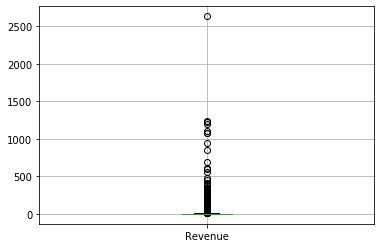

In [68]:
plt.figure()
bp = revenue.boxplot()

Видно, что по дохлдам есть выбросы, избавимся от них

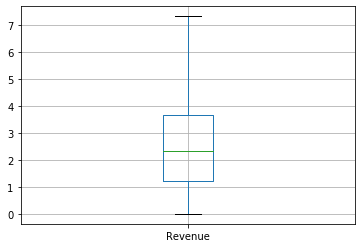

In [69]:
plt.figure()
bp = revenue[revenue['Revenue'] < 7.35].boxplot()

In [70]:
revenue[revenue['Revenue'] < 7.35].describe()

,Revenue
count,40952.000000
mean,2.693002
std,1.865099
min,0.000000
25%,1.220000
50%,2.320000
75%,3.670000
max,7.340000


# <font color='green'>Комментарий наставника</font> 
Не настаиваю, что тут ошибка, но просто интересно: есть гипотезы, почему такие ритмичные пики появляются на гистограмме ниже?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd41fa3aa58>]],
      dtype=object)

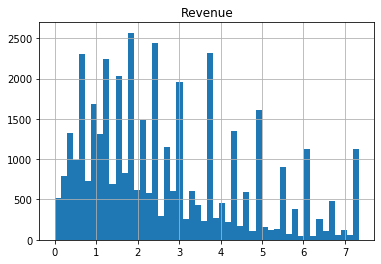

In [71]:
revenue[revenue['Revenue'] < 7.35].hist(bins = 50)

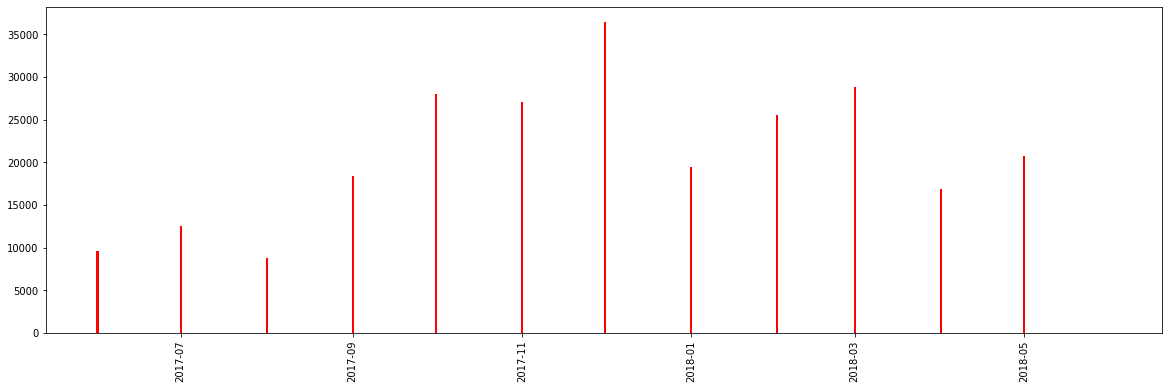

In [72]:
fig, ax = plt.subplots()
ax.bar(revenue_month['order_month'], revenue_month['Revenue'], color = 'red')
fig.set_figwidth(20)    #  ширина и
fig.set_figheight(6)    #  высота "Figure"
plt.xticks(rotation='vertical')
plt.show()

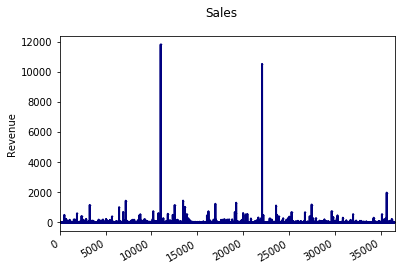

In [73]:
revenue_uid['Revenue'].plot(lw=2, colormap='jet', marker='x', markersize=1, title='Sales', subplots=True)
plt.ylabel('Revenue')
plt.show()

# <font color='blue'>Вывод</font> 

Можно предположить следующие причины таких пиков:
   1. Влияние сезонности от августа до января происходит рост покупки билетов. Дешевая замена развлечения на выходных или вечером.
   2. Потенциально влияние громких премьер то же под вопросом т.к. октябре доход больше, хотя небыло крупных кинопримьер, а в ноябре было 2 кинопримьеры, а доход полученный от продажи меньше. Аналогичная ситуация для февраля и марта.
   3. Есть клиенты, которые пользуются сервисом постоянно

In [74]:
revenue.head()

,Buy Ts,start_date_purchase,Revenue,order_month
0,2017-06-01 00:10:00,2017-06-01 00:10:00,17.00,2017-06-01
1,2017-06-01 00:25:00,2017-06-01 00:25:00,0.55,2017-06-01
2,2017-06-01 00:27:00,2017-06-01 00:27:00,0.37,2017-06-01
3,2017-06-01 00:29:00,2017-06-01 00:29:00,0.55,2017-06-01
4,2017-06-01 07:58:00,2017-06-01 07:58:00,0.37,2017-06-01


Однозначно можно сказать, что большенство пользователей приносит доход в диапазоне [0;4,28] денежных единиц и медианное значение дохода с одного клиента составляет 2,44 денежные единицы

Расчитаем LTV в разрезе месяцев


In [75]:
orders['order_month'] = orders['Buy Ts'].astype('datetime64[M]')

In [76]:
first_orders = orders.groupby('Uid').agg({'order_month': 'min'}).reset_index() 

In [77]:
first_orders.columns = ['Uid', 'first_order_month']

In [78]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'Uid': 'nunique'}).reset_index() 

In [79]:
cohort_sizes.columns = ['first_order_month', 'n_buyers']
orders_new = pd.merge(orders,first_orders, on='Uid')

In [80]:
cohorts = orders_new.groupby(['first_order_month','order_month']).agg({'Revenue': 'sum'}).reset_index()

In [81]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

In [82]:
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')

In [83]:
report['age'] = report['age'].round().astype('int')

In [84]:
report['ltv'] = report['Revenue'] / report['n_buyers'] 

In [85]:
result = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round()

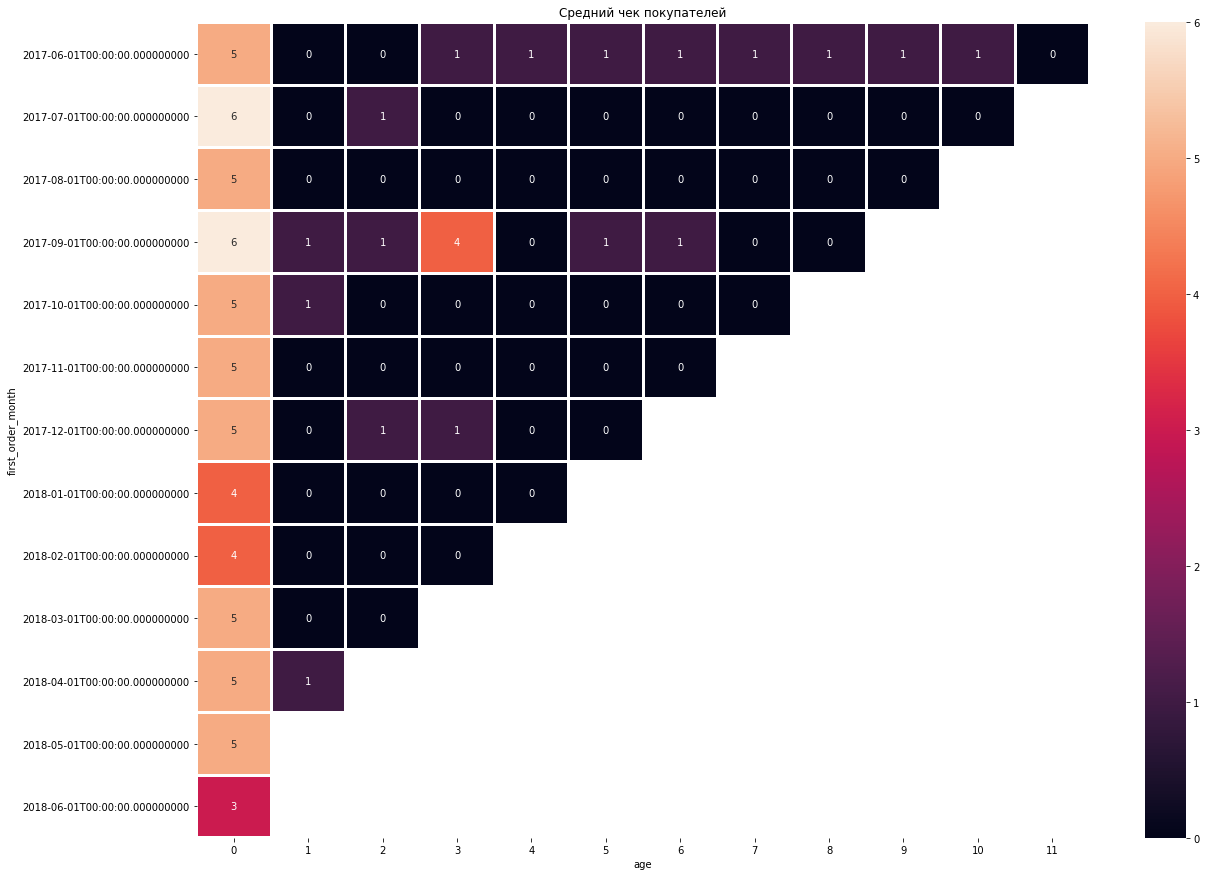

In [86]:
plt.figure(figsize=(20, 15))
plt.title('Средний чек покупателей')
sns.heatmap(result, annot=True, fmt='.0f', linewidths=2, linecolor='white')

Вывод
----
   1. В первый месяц пользователи тратят от 3 до 6 д.е., что выше среднего чека в целом за период. 
   2. Видно, что кроме посетителей которые начали пользоваться в __июле 2017__, __сентябре 2017__ и __апреле 2018__ происходит  отток пользователей сервиса.
   3. Клинеты, которые продолжают пользоваться сервисом, резко снижают свои расходы и средний чек ниже среднего по выборке на 59%. 
   
__Общими словами: наблюдается некий WOW-эффект: как только пользователь начинает пользоваться сервисом он достаточно много тратит, но очень быстро теряет интерес и начинает тратить мало или вообще уходит из сервиса__

Проанализируем процент удержание клиентов в рамках когорт в месяц

In [87]:
orders_new['cohort_lifetime'] = orders_new['order_month'] - orders_new['first_order_month']
orders_new['cohort_lifetime'] = orders_new['cohort_lifetime'] / np.timedelta64(1,'M')
orders_new['cohort_lifetime'] = orders_new['cohort_lifetime'].astype(int)

In [88]:
cohorts_retention = orders_new.groupby(['first_order_month','cohort_lifetime']).agg({'Uid':'nunique'}).reset_index()
inital_users_count = cohorts_retention[cohorts_retention['cohort_lifetime'] == 0][['first_order_month','Uid']]
inital_users_count = inital_users_count.rename(columns={'Uid':'cohort_users'})
cohorts_retention = cohorts_retention.merge(inital_users_count,on='first_order_month')
cohorts_retention['retention'] = cohorts_retention['Uid'] /cohorts_retention['cohort_users']

In [89]:
retention_pivot = cohorts_retention.pivot_table(index='first_order_month',columns='cohort_lifetime',values='retention',aggfunc='sum')

In [90]:
orders_new.head()

,Buy Ts,Revenue,Uid,start_date_purchase,order_month,first_order_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0


# <font color='red'>~__Здесь начинаю выделять когорты по неделям__~</font> 

<font color='red'>СПАСИБО</font> 
-----

In [91]:
first_orders_dates_week = orders_new.groupby('Uid')[['Buy Ts']].min()
first_orders_dates_week.columns = ['f_date']
orders_new = orders_new.join(first_orders_dates_week,on='Uid')

# <font color='green'>Комментарий наставника</font> 
В попытках разобраться я наткнулся на следующие штуки. Кажется, это не приводит к ошибкам, но имеет смысл почистить, чтобы не создавать путаницу 

1. f_date - это первый момент покупки
2. first_order_month - это первый месяц покупки полученный из того же Buy Ts

А вот тут в один столбец идет два подряд присвоения, т.е. одно из вычислений лишнее/ошибочное?
```
orders_new['date_purchase'] = orders_new['f_date'].dt.date
orders_new['date_purchase'] = pd.to_datetime(orders_new['first_order_month'], format="%Y-%m-%d")
```


In [92]:
orders_new['date_order'] = orders_new['Buy Ts'].dt.date
orders_new['date_order'] = pd.to_datetime(orders_new['date_order'], format="%Y-%m-%d")
orders_new['date_purchase'] = orders_new['f_date'].dt.date
orders_new['date_purchase'] = pd.to_datetime(orders_new['date_purchase'], format="%Y-%m-%d")

In [93]:
orders_new['activity_week'] = pd.to_datetime(orders_new['date_order'], unit='d') - pd.to_timedelta(orders_new['date_order'].dt.dayofweek, unit='d')
orders_new['first_activity_week'] = pd.to_datetime(orders_new['date_purchase'], unit='d') - pd.to_timedelta(orders_new['date_purchase'].dt.dayofweek, unit='d')
orders_new['cohort_lifetime_week'] = orders_new['activity_week'] - orders_new['first_activity_week']
orders_new['cohort_lifetime_week'] = orders_new['cohort_lifetime_week'] / np.timedelta64(1,'W')
orders_new['cohort_lifetime_week'] = orders_new['cohort_lifetime_week'].astype(int)


# <font color='red'>~__Здаесь явно видна ошибка но не понимаю в чем__~</font> 

# <font color='green'>Комментарий наставника</font> 

А в чем именно ошибка с твоей точки зрения? 
Тебя смущает, что кол-во Uid не убывает монотонно? Если да, то это нормально, т.к. чтобы падало монотонно, нужно в тех, кто пробыл на сайте 1 неделю включить всех, кто пробыл на сайте больше одной недели. 

По крайней мере, я так рисую себе retention. Если да, то нужен какой-нибудь cumsum по dataframe и тогда будут более логичные цифры.

In [94]:
cohorts_retention_week = orders_new.groupby(['first_activity_week','cohort_lifetime_week']).agg({'Uid':'nunique'}).reset_index()
inital_users_count_week = cohorts_retention_week[cohorts_retention_week['cohort_lifetime_week'] == 0][['first_activity_week','Uid']]
cohorts_retention_week.head()

,first_activity_week,cohort_lifetime_week,Uid
0,2017-05-29,0,295
1,2017-05-29,1,13
2,2017-05-29,2,8
3,2017-05-29,3,3
4,2017-05-29,4,5


In [95]:
cohorts_retention_week.Uid.sum()

43298

In [96]:
inital_users_count_week = inital_users_count_week.rename(columns={'Uid':'cohort_users_week'})

In [97]:
cohorts_retention_week = cohorts_retention_week.merge(inital_users_count_week,on='first_activity_week')

In [98]:

cohorts_retention_week['retention'] = cohorts_retention_week['Uid'] /cohorts_retention_week['cohort_users_week']

retention_pivot_week = cohorts_retention_week.pivot_table(index='first_activity_week',columns='cohort_lifetime_week',values='retention',aggfunc='sum')


# <font color='green'>Комментарий наставника</font> 
Не исключено, что такая картина связана с выходами громких фильмов и праздниками. 
Если громкий фильм вышел 1 ноября, то вся когорта связанная с 1 ноября на следущей неделе будет иметь просадку почти в ноль, а предыдущие когорты, наоборот, будут иметь небольшой всплеск в соответствующей неделе.

Может быть построить график общих сборов по неделям? Тогда, возможно, увидим аномальные месяцы и/или недели и станет понятно, что происходит? 

In [99]:
retention_pivot_week.fillna(' ')

cohort_lifetime_week,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
first_activity_week,,,,,,,,,,,,,,,,,,,,,
2017-05-29,1.0,0.0440678,0.0271186,0.0101695,0.0169492,0.0169492,0.0101695,0.0169492,0.00677966,0.0135593,...,0.0101695,0.0101695,0.0169492,0.0237288,0.00677966,,0.0101695,0.0101695,0.0169492,0.0135593
2017-06-05,1.0,0.0173267,0.00742574,0.0123762,0.00990099,0.0111386,0.00742574,0.00866337,0.00742574,0.0049505,...,0.00371287,0.00742574,0.0123762,0.00371287,0.0049505,0.00371287,0.00990099,0.00990099,0.0148515,
2017-06-12,1.0,0.020339,0.00677966,,0.0101695,0.0101695,0.00338983,,0.00677966,0.0135593,...,0.00338983,0.00338983,0.0135593,,0.00338983,,0.0169492,0.0101695,,
2017-06-19,1.0,0.0339506,0.00617284,0.00925926,0.00617284,,,,,0.00308642,...,0.0123457,0.00925926,0.00617284,0.00617284,,0.00925926,,,,
2017-06-26,1.0,0.0130548,0.0156658,0.0156658,0.0078329,0.00522193,0.0104439,0.00522193,0.0078329,0.0104439,...,0.0078329,0.00261097,0.00261097,0.0104439,0.00261097,0.00261097,,,,
2017-07-03,1.0,0.0226131,0.00753769,0.0125628,0.0100503,0.00753769,0.00502513,0.0125628,0.0125628,0.0100503,...,0.00502513,0.00502513,0.00502513,0.00502513,0.00251256,,,,,
2017-07-10,1.0,0.027027,0.011583,0.0019305,0.003861,0.003861,0.00579151,0.011583,0.011583,0.00579151,...,0.00579151,0.00772201,0.0019305,0.00579151,,,,,,
2017-07-17,1.0,0.0117647,0.0134454,0.00336134,0.00504202,0.00336134,0.00840336,0.00336134,0.00336134,0.00672269,...,0.00168067,,0.00672269,,,,,,,
2017-07-24,1.0,0.0174216,0.010453,0.010453,0.00696864,0.0139373,0.010453,0.00696864,0.010453,0.0139373,...,,0.00348432,,,,,,,,


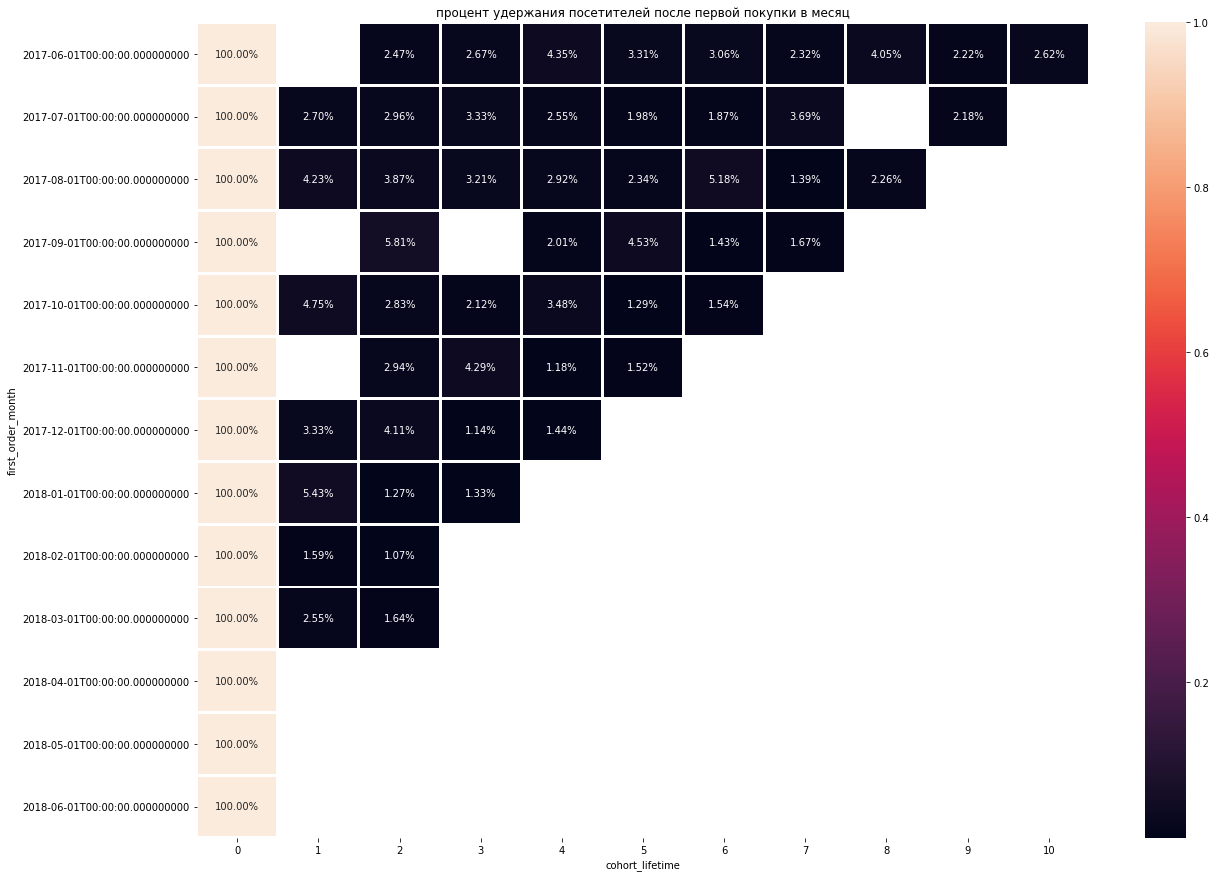

In [100]:
plt.figure(figsize=(20, 15))
plt.title('процент удержания посетителей после первой покупки в месяц')
sns.heatmap(retention_pivot, annot=True, fmt='.2%', linewidths=2, linecolor='white')

Вывод
----
Как видно процент удержания клиентов незначительный. Определить тендецию удержания  потребителей по когортам не возможно. Наблюдаются случаи когда после первого месяца покупки покупки отсутсвуют вообще, так и есть наростание потребителей, которые покупают.

<font color='red'>Дополнительный вывод</font> 
------

__Резкого оттока нет по клиентам. И ранее в анализе было определено, что пользователи  декстопных девайсов принимают решение о покупке в течение 1 недели__

Оценим маркетинговые затраты на привлечвение клиентов в целом

In [101]:
costs['costs_month'] = costs['dt'].astype('datetime64[M]') 
monthly_costs = costs.groupby('costs_month').agg({'costs':'sum'})

In [102]:
report.head()

,first_order_month,n_buyers,order_month,Revenue,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531


In [103]:
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='costs_month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new['roi'] = report_new['ltv'] / report_new['cac']

In [104]:
report_new.head()

,first_order_month,n_buyers,order_month,Revenue,age,ltv,costs,cac,roi
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,18015.0,8.905091,0.530530
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329,18015.0,8.905091,0.054500
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637,18015.0,8.905091,0.049145
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671,18015.0,8.905091,0.107205
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531,18015.0,8.905091,0.114825


In [105]:
output_cac = report_new.pivot_table(
        index='first_order_month', 
        values='costs', 
        aggfunc='mean').reset_index()

In [106]:
output_cac

,first_order_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


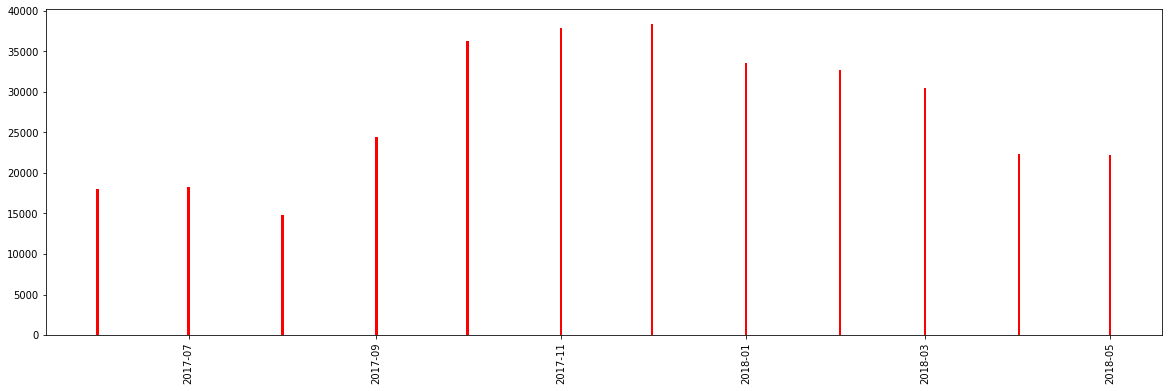

In [107]:
fig, ax = plt.subplots()
ax.bar(output_cac['first_order_month'], output_cac['costs'], color = 'red')
fig.set_figwidth(20)    #  ширина и
fig.set_figheight(6)    #  высота "Figure"
plt.xticks(rotation='vertical')
plt.show()

In [108]:
output = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='roi', 
        aggfunc='mean')


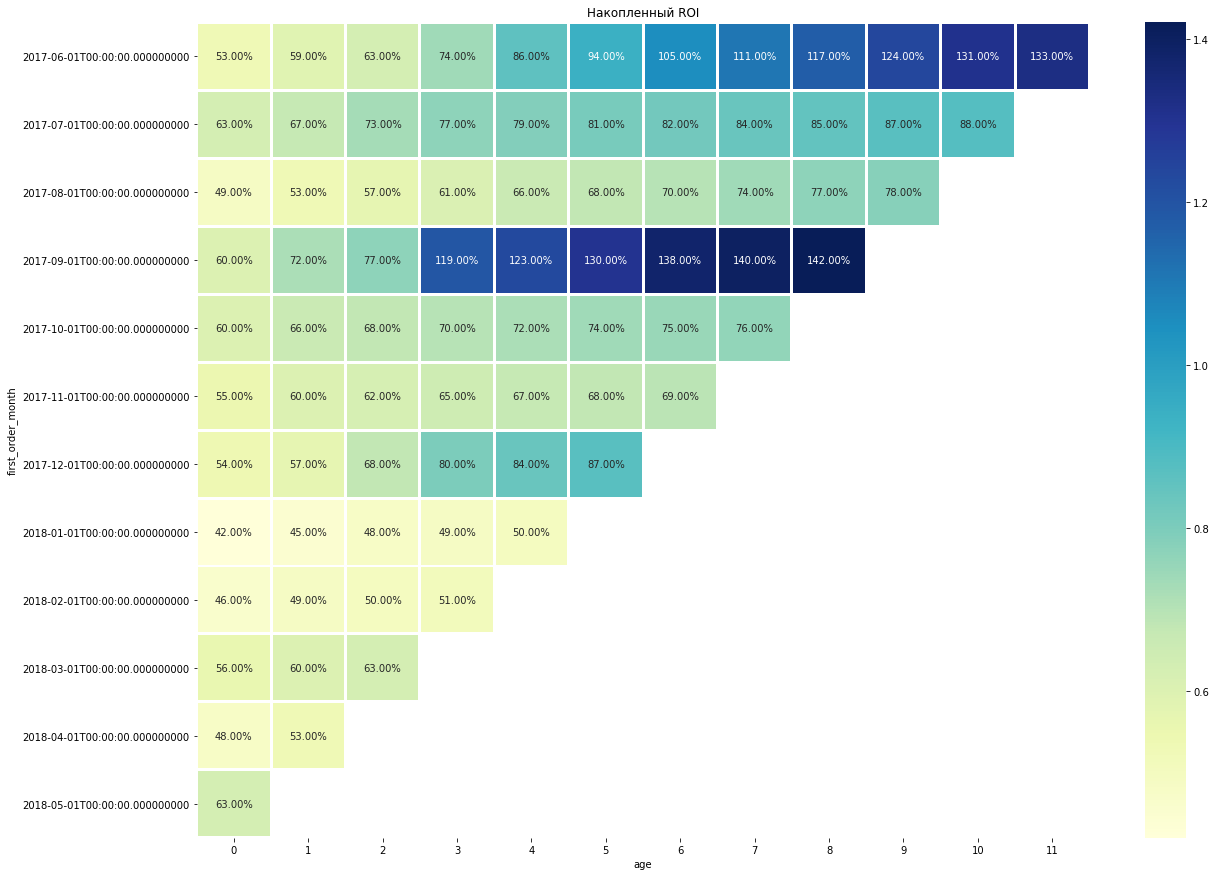

In [109]:
plt.figure(figsize=(20, 15))
plt.title('Накопленный ROI')
sns.heatmap(output.cumsum(axis=1).round(2), annot=True, fmt='.2%', cmap="YlGnBu", linewidths=2, linecolor='white')

Вывод 
----

   1. Маркетинговые затраты на привлечение не окупаются в целом. Окупаются только клиенты привлеченные в июле и сентябре.
   2. Затраты в рекламу ни как не связаны с качеством посетителей. 

Рассмотрим затраты в рекламу и ее окупаемость в разрезе рекламных средств

In [110]:
visits.head()

,Uid,Device,End Ts,Source Id,Start Ts,session_duration_minutes,application_start_date,session_year,session_month,session_week,session_date
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,18,2017-12-20 17:20:00,2017,12,51,2017-12-20
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,28,2018-02-19 16:53:00,2018,2,8,2018-02-19
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,0,2017-07-01 01:54:00,2017,7,26,2017-07-01
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,24,2018-03-09 20:05:00,2018,5,20,2018-05-20
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,0,2017-12-27 14:06:00,2017,12,52,2017-12-27


In [111]:
orders.head()

,Buy Ts,Revenue,Uid,start_date_purchase,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01


In [112]:
costs.head()

,source_id,dt,costs,costs_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [113]:
ad_sum = costs.pivot_table(
        index='source_id', 
        values='costs', 
        aggfunc='sum')
ad_sum['shape'] = ad_sum['costs'] / ad_sum['costs'].sum()

In [114]:
ad_sum = ad_sum.sort_values(by = 'costs')

In [115]:
ad_visit = visits.groupby('Source Id').agg({'Uid': 'nunique'})
ad_visit['shape'] = ad_visit['Uid'] / ad_visit['Uid'].sum()
ad_visit = ad_visit.sort_values(by = 'shape')

In [116]:
ad_visit

,Uid,shape
Source Id,,
6,6,0.000022
7,34,0.000122
10,8067,0.029032
9,9264,0.033339
1,18999,0.068374
2,26245,0.094451
5,56974,0.205038
3,74756,0.269032
4,83525,0.300590


In [117]:
ad_sum

,costs,shape
source_id,,
9,5517.49,0.016764
10,5822.49,0.017690
1,20833.27,0.063298
2,42806.04,0.130058
5,51757.10,0.157254
4,61073.60,0.185560
3,141321.63,0.429377


Вывод
----
   1. В явном виде, на продвижение сервиса Яндекс.Афиши затрачиваются денежные средства на рекламные источники  1, 2, 3, 4, 5, 9, 10. 
      - 3 источник 42,94% бюджета, 26,90% привлеченных посетителей;
      - 4 источник 18,56% бюджета, 30,06% привлеченных посетителей;
      - 5 источник 15,72% бюджета, 20,50% привлеченных посетителей;
      - 2 источник 13,01% бюджета, 9.4% привлеченных посетителей;
      - 1 источник 6,3% бюджета, 6.8% привлеченных посетителей;
      - 10 источник 1,76% бюджета, 2,9% привлеченных посетителей;
      - 9 источник 1,67% бюджета, 3,33% привлеченных посетителей;

# Резюме о проделанной работе

 Построины отчёты и посчитаны метрики
   
   1. __Продукт__:
      - Сколько людей пользуются в день, неделю, месяц?
      - Сколько сессий в день?
      - Сколько длится одна сессия?
      - Как часто люди возвращаются?
   2. __Продажи__:
      - Когда люди начинают покупать?
      - Сколько раз покупают за период?
      - Какой средний чек?
      - Сколько денег приносят? (LTV)
   3. __Маркетинг__
      - Сколько денег потратили? Всего / на каждый источник / по времени.
      - Сколько стоило привлечение одного покупателя из каждого источника?
      - На сколько окупились расходы? (ROI)


Общий вывод по анализу продукта
-----


     - видно, что распределние "время нахождения" осуществляется по распредлению Пуасона. Медианное время нахождения посетителя на сайте равняется __3 минутам__;
     - длительность сессии зависит от девайса, с которого заходили: с desktop медианное значение времени __4 минуты__ (__7 минут__ без пустых (меньше __1 минуты__) заходов);
     - Большое количество пустых заходов, при этом доля пустых сессий (__время < 1 минуты__) для девайсов __touch__ составляет __16,83%__, для desktop __12,83%__;
     - общее количество посещений в день составляет 984 визитов. Без учета сессий длительностью меньше 1 минуты 886 визитов в день;
     - количество пользователей в целом:
        - количество пользователей в день __984 человек__;
        - количество пользователей в неделю __6764 человек__;
        - количество пользователей в месяц __29877 человек__;
      - количество пользователей для смартфонов и планшетов:
         - количество пользователей в день для девайсов touch __266 человек__;
         - количество пользователей в неделю для девайса touch __1823 человек__;
         - количество пользователей в месяц для девайса touch __8051 человек__;
      - количество пользователей для декстопных девайсов:
         - количество пользователей в день для девайса desktop __719 человек__;
         - количество пользователей в неделю для девайса desktop __4941 человек__;
         - количество пользователей в месяц для девайса desktop __21825 человек__;
      - количество уникальных пользователей в целом:
         - количество уникальных пользователей в день __907 человек__;
         - количество уникальных пользователей в неделю __5716 человек__;
         - количество уникальных пользователей в месяц __23228 человек__;
      - Количество уникальных пользователей для смартфонов и планшетов
         - количество уникальных пользователей в день для девайса touch __252 человек__;
         - количество уникальных пользователей в неделю для девайса touch __1634 человек__;
         - количество уникальных пользователей в месяц для девайса touch __6825 человек__;
      - количество уникальных пользователей для декстопных девайсов:
         - количество уникальных пользователей в день для девайса desktop __659 человек__;
         - количество уникальных пользователей в неделю для девайса desktop __4129 человек__;
         - количество уникальных пользователей в месяц для девайса desktop __16724 человек__;
      - количество уникальных пользователей, которые приходят с декстопных девайсов на __145%__ больше, чем с планшетов и мобильников;
      - значение метрики __Sticky Factor__ в целом и в разрезе девайсов (месячное) низкое, что говорит о том, что пользователи не задерживаются в сервисе, вероятно его удержание очень низкое и в нем отсутствует пользовательская база, которая необходима для того, чтобы генерировать доход сервиса.
      - как видно наилучшими результатами по привлечению клиентов обладают рекламный источник № 6 и 7, однако в раннем анализе было видно, что на данный вид рекламы приходится незначительное число переходов. Стоит обратить внимение на рекламные источники 1 и 2, так как показатель удержания повторных клиентов для них больше чем всреднем по выборке;
      - количество общих визитов, которые приходят с декстопных девайсов на __171%__ больше, чем с планшетов и мобильников;
      - пользователи в большенстве своем заходят в Яндекс.Афиши один раз в день. Для пользователей с декстопных девайсов заходить могут больше одного раза в течении недели (_можно сделать предположение, что период планирования для пользователей декстопных девайсов приблизительно равен одной недели_). Менее __25%__ пользователей заходят в сервис более двух раз в месяц.
      - параметры воронки продаж: из 100% пользователей 16% делает одну покупку, из которых 38,04% совершают повторную покупку т.е. из 100% совершает 2 и более покупок только 6% посетителей.


Общий вывод по анализу покупок
----
   - большенство потребителей покупает в тот же день, в который первый раз посетили сервис Яндекс.Афиши в течении 1 минуты;
   - однозначно можно сказать, что большенство пользователей приносит доход в диапазоне [0;4,28] денежных единиц и медианное значение дохода с одного клиента составляет 2,44 денежные единицы;
   - в первый месяц пользователи тратят от 3 до 6 д.е., что выше среднего чека в целом за период; 
   - кроме посетителей которые начали пользоваться в __июле 2017__, __сентябре 2017__ и __апреле 2018__ происходит  отток пользователей сервиса;
   - клинеты, которые продолжают пользоваться сервисом, резко снижают свои расходы и средний чек ниже среднего по выборке на 59%; 
   - __общими словами: наблюдается некий WOW-эффект: как только пользователь начинает пользоваться сервисом он достаточно много тратит, но очень быстро теряет интерес и начинает тратить мало или вообще уходит из сервиса__
   - определить тендецию удержания  потребителей по когортам не возможно. Наблюдаются случаи когда после первого месяца покупки покупки отсутсвуют вообще, так и есть наростание потребителей, которые покупают;  

Общий вывод по анализу маркетинга
----
    - маркетинговые затраты на привлечение не окупаются в целом. Окупаются только клиенты привлеченные в июле и сентябре;
    - затраты в рекламу ни как не связаны с качеством посетителей;
    - в явном виде, на продвижение сервиса Яндекс.Афиши затрачиваются денежные средства на рекламные источники  1, 2, 3, 4, 5, 9, 10:
        - 3 источник 42,94% бюджета, 26,90% привлеченных посетителей;
        - 4 источник 18,56% бюджета, 30,06% привлеченных посетителей;
        - 5 источник 15,72% бюджета, 20,50% привлеченных посетителей;
        - 2 источник 13,01% бюджета, 9.4% привлеченных посетителей;
        - 1 источник 6,3% бюджета, 6.8% привлеченных посетителей;
        - 10 источник 1,76% бюджета, 2,9% привлеченных посетителей;
        - 9 источник 1,67% бюджета, 3,33% привлеченных посетителей.
 
<font color='red'>Дополнительный вывод</font> 
------
 
 __Как вывод посмотреть как измениться число посетителей, число первых покупок и удержание клиентов если перераспределить бюджет в пользу рекламных источников 1,2 и 6,7(по поводу них не уверен так как слишком мало данных).___

------------

# Рекомендации

__Яндекс.Афиши не окупается - это основная проблема.__ 
   1. _Первая проблема - низкий процент удержания покупателей._ При достаточно качественной работы маркетологов по продвижению данного сервиса и высокому привлечению посетителей, наблюдается отказ потребителей от вторичного его использования. Только две когорты имеют процент удержания более 3% и  этого стало достаточно, для окупаемости затрат на рекламу и получению прибыли.
   2. _Вторая проблема - это небольшей средний чек при повтороной покупке_, что также является причиной недостаточной эффективности работы сервиса. Для когорты, которая начала покупки в сентябре 2017 г., высокий средний чек позволил окупить затраты на их привлечение в течении 4 месяцев.
   3. _Третья проблема - меньший приход пользователей с планшетов и смартфонов._ Данного типа клиентов на 145% меньше чем со стационарных гаджетов. При этом стоит отметить, что среднее время сессии для последних в 1,75 раза превышает время нахождения пользователей планшетов и смартфонов.
   
Вывод
---
Оценить причины такой ситуации достаточно сложно однако можно дать следующие рекомендации:

__Продукт__
   1. Произвести анализ сервиса с точки зрения "опыта пользователя" и определить, что им не нравится.
   2. __Обязательно__ проанализировать мобильную версию Яндекс.Афиши и попытаться оценить, что пользователю не нравится.
   3. Провести дополнительные исследования логотипа сервиса и отношение посетитилей к нему. Возможно стоит его изменить.
   4. Возможно стоит рассмотреть возможность проведение нескольких сессий фокус-uheg для оценки удобства пользования сервисом.
   
__Конкуренты__
   5. Оценить действия конкурентов и, соотвественно, оценить как пользователи на него реагировали.
   6. Оценить стоимость перехода с одного агрегатора продажи билетов на другой, возможно в этом тоже есть проблема.
   
__Лояльность__
   7. Необходимо разивтие программы лояльности для пользователей: в сервисе уже есть получение баллов за отмечание интересных мест, событий и мероприятий, которые можно обменять на рубли. Необходимо развитие данного направления путем введения рейтинга человека, объявление лучшего и т.п. Возможно внедрение поощерения за самую быструю оценку "правильную оценку" с написанием поста. 
   8. Комбинированные продажи билетов на мероприятия, внедрение систем перекресных продаж.
   9. Создание системы локальной оценки лекций (семинаров, обучения) в режиме реального времени и т.п.
   10. Персонализированные купоны и т.п.
   ........
   
Собственный опыт:

Зарание извеняюсь полного сервиса у меня в регионе не подключено. Однако могу высказать свои небольшие замечания:
   1. Не везде качественная фотография при просмотре мероприятий (Минск).
   2. На большем мониторе как то не рационально размещена информация (Минск). Для Москвы лучше (это личное мнение). 
   3. Очень много рекламы, что разражает для "сервиса-посредника" (Минск). Для локации в Москве рекламы количество рекламы такое же, "но она не так бросается в глаза", наполнение страницы лучше. 
   4. Немного притормаживает, когда пользовался в геолокации в Москве.
   5. Порадавало наличие акций по стимулированию, к акциям я бы добавил "купоны" (дополнительно надо проанализировать)
   6. Мобильная в сравнении с конкурентами (минскими) например Афиша тут бай, ticketpro.by, kvitki.by, bycard.by  и т.п. смотрится хуже (личное мнение).
   7. Мы не знаим действия конкурентов в данный период и не можем оценить как это повлияло на наших клиентов.

__Распределение бюджета по рекламным каналам - вторая проблема__
   1. Возможно стоит изменить структуру распределения бюджета между рекламными источниками т.к. существуют источники с меньшим бюджетом, приносящим больше поток визитов. Для этого необходимо проанализировать эластичность изменения количества уникальных посетителей на изменение бюджета. 
      - можно попробовать уменьшить бюджет 3 рекламного источника и увеличить бюджет рекламных источников № 9, 10, 1;
      - возможно перераспределить бюджет от рекламного источника №3 к рекламному источнику №4, и от рекламного источника № 2 к рекламному источнику № 5.
      - не понятна роль источников 6 и 7, в которые не вкладываются ресурсы. Возможно вложение денежных средств позволит существенно увеличить приток уникальных поситителей. 
   
------------

<font color='red'>Дополнительный вывод </font> 
-----

__По фактическим данным можно сказать, что потенциалом роста является удержание клиентов. И основным выходом для удержания пользователей является:__
   - повесить метки на сбор информации о пользовании сервисом, для того что бы определить что нравиться а что не нравится пользователю;
   - анализ показал, что чистое привлечение не эффектино (фактически убыточно). И это мы анализируем только затраты на привлечение без учета других расходов;
   - параллельно с затратами на привлечение стоит вкладывать во внутренние развитие сервиса направленное на повышение такой пользовательской хараткеристики как __"индивидуальная стоимость перехода с одного сервиса на другой__" - она должна быть психологически неудобно для пользователя;
   - необходимо разработать маркетинговый план по "прививанию лояльности" клиентам к использованию сервиса;
   - все выше сказанное должно базироваться на формировании культуры посещения различных мероприятий и генерирование субкультур потребления


